## Predictions: Hourly

In [1]:
import pandas as pd
import numpy as np
import joblib
from datetime import timedelta

model = joblib.load("./humanitys_last_hope.joblib")

X_inf = pd.read_csv("data/inference_hourly_48.csv", parse_dates=True)
consumption = pd.read_excel("data/20251111_JUNCTION_training.xlsx", sheet_name="training_consumption", parse_dates=True).iloc[-24:]
groups = pd.read_excel("data/20251111_JUNCTION_training.xlsx", sheet_name="groups")

In [2]:
X_timestamps = X_inf["measured_at"]
X_inf = X_inf.drop(["Unnamed: 0", "measured_at"], axis=1)

In [ ]:
# each hourly prediction needs to have its own week backlog to reference
def append_to_time_cache(pred_array, timestamp, cache, ids):
    pred = {
        c: pred_array[0][i].item() for i, c in enumerate(ids) 
    }
    pred["measured_at"] = timestamp

    cache = pd.concat([cache, pd.DataFrame([pred])], ignore_index=True)
    cache["measured_at"] = pd.to_datetime(cache["measured_at"], format="mixed")

    return cache


def fill_input_lags_1_2_24(X_inf, t, target_time, cache, ids):
    target_time = pd.to_datetime(target_time)
    past_time_1 = target_time - timedelta(hours=1)
    past_time_2 = target_time - timedelta(hours=2)
    past_time_24 = target_time - timedelta(hours=24)

    matched_1 = cache[cache["measured_at"] == past_time_1]
    matched_2 = cache[cache["measured_at"] == past_time_2]
    matched_24 = cache[cache["measured_at"] == past_time_24]
    
    for i in ids:
        past1 = f"lag_1h_{i}"
        past2 = f"lag_2h_{i}"
        past24 = f"lag_24h_{i}"

        X_inf.loc[t, past1] = matched_1[i].values[0].item()
        X_inf.loc[t, past2] = matched_2[i].values[0].item()
        X_inf.loc[t, past24] = matched_24[i].values[0].item()
    

In [4]:
ids = [n.item() for n in groups["group_id"].values]

n = len(X_inf)

out = model.predict(X_inf.iloc[[0]])
consumption = append_to_time_cache(out, X_timestamps[0], consumption, ids)

for t in range(1, n):
    fill_input_lags_1_2_24(X_inf, t, X_timestamps[t], consumption, ids)
    out = model.predict(X_inf.iloc[[t]])
    consumption = append_to_time_cache(out, X_timestamps[t], consumption, ids)


In [ ]:
consumption[-48:] # these are the predictions

,measured_at,28,29,30,36,37,38,39,40,41,...,697,698,705,706,707,708,709,738,740,741
24,2024-10-01 00:00:00+00:00,2.599662,0.181376,0.525121,0.478012,0.196140,0.481563,0.176714,0.163707,0.459963,...,0.133341,0.460570,0.161542,0.363122,0.169830,0.410594,0.159380,0.524477,0.142175,0.483524
25,2024-10-01 01:00:00+00:00,3.036213,0.138659,0.543945,0.495241,0.151198,0.496152,0.135292,0.146263,0.451848,...,0.117661,0.566435,0.126962,0.294843,0.134668,0.343345,0.124772,0.561978,0.092928,0.554661
26,2024-10-01 02:00:00+00:00,3.630690,0.205768,0.679784,0.521582,0.181971,0.532957,0.151156,0.169261,0.519834,...,0.161963,0.638773,0.144060,0.327858,0.165509,0.476807,0.159260,0.739091,0.157846,0.695481
27,2024-10-01 03:00:00+00:00,3.421267,0.162866,0.607861,0.638799,0.197957,0.567263,0.156738,0.167233,0.506168,...,0.134010,0.627926,0.168324,0.380935,0.165914,0.429174,0.165299,0.577033,0.106233,0.579627
28,2024-10-01 04:00:00+00:00,3.214698,0.151120,0.658498,0.565430,0.205829,0.608739,0.207223,0.193818,0.572020,...,0.125547,0.550528,0.204026,0.457477,0.197684,0.479822,0.168440,0.586572,0.092417,0.564056
29,2024-10-01 05:00:00+00:00,3.344055,0.169436,0.628285,0.656433,0.213458,0.619680,0.190352,0.190704,0.546362,...,0.156806,0.674049,0.186385,0.415202,0.190665,0.527429,0.201641,0.637419,0.145114,0.649632
30,2024-10-01 06:00:00+00:00,3.458741,0.210112,0.730458,0.376723,0.261066,0.752057,0.247948,0.252880,0.717309,...,0.153594,0.597334,0.279891,0.611999,0.250831,0.609729,0.243670,0.647816,0.109095,0.571728
31,2024-10-01 07:00:00+00:00,3.530188,0.203355,0.709994,0.359195,0.225906,0.656963,0.231049,0.217519,0.659660,...,0.150876,0.581429,0.241094,0.507521,0.227341,0.553940,0.198810,0.682782,0.112236,0.598858
32,2024-10-01 08:00:00+00:00,3.610763,0.219789,0.755046,0.319742,0.239171,0.680432,0.226646,0.241077,0.733022,...,0.147157,0.570060,0.242993,0.527151,0.241846,0.561770,0.197779,0.720299,0.104562,0.559033
33,2024-10-01 09:00:00+00:00,3.084289,0.153335,0.559513,0.464380,0.181858,0.523471,0.155425,0.161085,0.517295,...,0.107120,0.535391,0.156885,0.367279,0.153845,0.411834,0.138438,0.537520,0.093424,0.490765


<Axes: ylabel='708'>

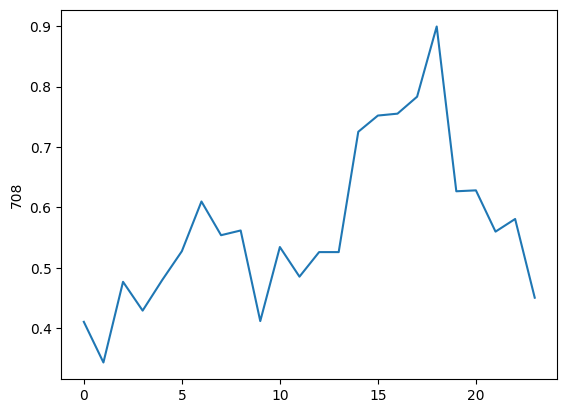

In [26]:
import seaborn as sns

sns.lineplot(consumption[-48:-24], x=range(24), y=708)

<Axes: ylabel='708'>

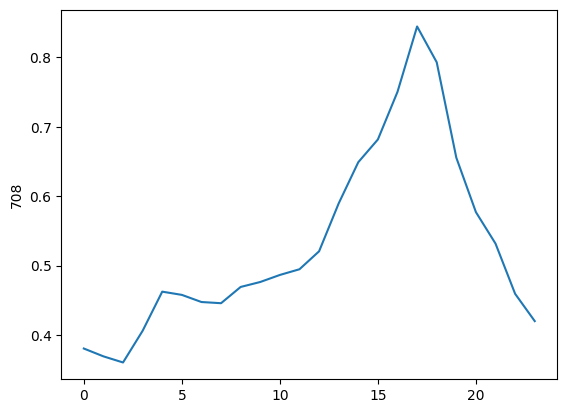

In [25]:
sns.lineplot(consumption[:-48], x=range(len(consumption[:-48])), y=708)

## Monthly

In [54]:
ids = [n.item() for n in groups["group_id"].values]


In [42]:
X_inf_m = pd.read_csv("data/months_to_submit.csv")
Xm_tr_cols = pd.read_csv("data/df_month_predict.csv")

Xm_tr_cols = Xm_tr_cols.drop(["measured_at", "Unnamed: 0"], axis=1)

X_inf_m = X_inf_m[Xm_tr_cols.columns]

import joblib

model = joblib.load("monthly.joblib")


preds = model.predict(X_inf_m)

In [65]:
pred_df = {
    idx: preds[:, i] for i, idx in enumerate(ids) 
}

pred_df = pd.DataFrame(pred_df)

In [72]:
pred_df.to_csv("data/1y_predicted.csv", sep=";", decimal=",")

## Fixing formatting

In [75]:
pred_hourly = pd.read_csv("data/48h_predicted.csv")

pred_hourly = pred_hourly.drop("Unnamed: 0", axis=1)
pred_hourly["measured_at"] = pd.to_datetime(pred_hourly["measured_at"])
pred_hourly["measured_at"] = pred_hourly["measured_at"].dt.strftime('%Y-%m-%dT%H:%M:%SZ')

pred_hourly.to_csv("data/48h_predicted.csv", sep=";", decimal=",")